In [42]:
import pandas as pd
import numpy as np
import tqdm
import os
import cv2
from random import shuffle
import h5py
from shutil import copy,move
size = 300
folder = 'train'
IMG_SIZE = 120
size = 120

In [46]:
def func():
    os.makedirs('val')
    for fold in os.listdir(folder):
        val_folds = os.path.join('val',fold)
        os.makedirs(val_folds)
        name = os.path.join(folder,fold)
        x = 0
        for file in os.listdir(name):
            file = os.path.join(name,file)
            move(file,val_folds)
            x += 1
            if x is 45:
                break
func()

In [47]:
def save(model):

    model_save = model.to_json()
    with open("weights_2inc.json","w") as json_file:
        json_file.write(model_save)

    model.save_weights("model_2inc.h5")
    print("SAVED")



In [48]:
from keras.layers import Dense,Conv2D
from keras.preprocessing.image import ImageDataGenerator,img_to_array, load_img
import math

In [49]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range = 50,
        shear_range=0.2,
        zoom_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
         )

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'train',
        shuffle = False,
        target_size=(300,400),
        batch_size=5,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        'val',
        shuffle = False,
        target_size=(300,400),
        batch_size=5,
        class_mode='categorical')


Found 3610 images belonging to 12 classes.
Found 540 images belonging to 12 classes.


In [1]:
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,Activation,Flatten,Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import RMSprop
from keras.utils import np_utils
import math

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
res_model = InceptionV3(weights = 'imagenet',include_top = False,input_shape = (300,400,3))

In [ ]:
rnf_train = res_model.predict_generator(train_generator)
rnf_val = res_model.predict_generator(validation_generator)

In [52]:
print(rnf_train.shape)

(3610, 8, 11, 2048)


In [53]:
rnf_val.shape

(540, 8, 11, 2048)

In [ ]:
np.save('rnf_train.npy',rnf_train)
np.save('rnf_val.npy',rnf_val)


In [7]:
rnf_train = np.load('rnf_train.npy')
rnf_val = np.load('rnf_val.npy')

In [94]:
model = Sequential()  
model.add(Flatten(input_shape=rnf_train.shape[1:]))  
model.add(Dense(512, activation='relu'))  
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))  
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(12, activation='softmax'))  

In [95]:
Y = train_generator.classes
print(Y)
Y_val = validation_generator.classes
print(Y.shape)
Y = np_utils.to_categorical(Y)
Y_val = np_utils.to_categorical(Y_val)

print(Y.shape)
print(Y_val.shape)

[ 0  0  0 ... 11 11 11]
(3610,)
(3610, 12)
(540, 12)


In [96]:
"""from keras.models import model_from_json
load_json = open("weights_2inc.json",'r')
loaded = load_json.read()
load_json.close()
load = model_from_json(loaded)
load.load_weights("model_inc.2inc.h5")
print("Loaded")
model_inc = load"""

'from keras.models import model_from_json\nload_json = open("weights_2inc.json",\'r\')\nloaded = load_json.read()\nload_json.close()\nload = model_from_json(loaded)\nload.load_weights("model_inc.2inc.h5")\nprint("Loaded")\nmodel_inc = load'

In [97]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_12 (Flatten)         (None, 180224)            0         
_________________________________________________________________
dense_18 (Dense)             (None, 12)                2162700   
Total params: 2,162,700
Trainable params: 2,162,700
Non-trainable params: 0
_________________________________________________________________


In [99]:
rms = RMSprop(lr = 0.0001)
model.compile(loss = 'categorical_crossentropy',optimizer = rms , metrics = ['accuracy'])

In [101]:
hist = model.fit(rnf_train,Y,epochs=25, batch_size=32,validation_data = (rnf_val,Y_val))

Train on 3610 samples, validate on 540 samples
Epoch 1/25
3610/3610 [==============================] - 11s 3ms/step - loss: 6.4119 - acc: 0.5030 - val_loss: 8.9408 - val_acc: 0.3463
Epoch 2/25
3610/3610 [==============================] - 11s 3ms/step - loss: 5.7842 - acc: 0.5753 - val_loss: 8.2613 - val_acc: 0.3796
Epoch 3/25
3610/3610 [==============================] - 10s 3ms/step - loss: 3.9571 - acc: 0.6634 - val_loss: 4.3844 - val_acc: 0.5148
Epoch 4/25
3610/3610 [==============================] - 10s 3ms/step - loss: 2.4281 - acc: 0.7609 - val_loss: 4.2095 - val_acc: 0.4870
Epoch 5/25
3610/3610 [==============================] - 10s 3ms/step - loss: 1.0416 - acc: 0.8767 - val_loss: 2.7449 - val_acc: 0.6037
Epoch 6/25
3610/3610 [==============================] - 10s 3ms/step - loss: 0.3253 - acc: 0.9230 - val_loss: 2.3459 - val_acc: 0.6333
Epoch 7/25
3610/3610 [==============================] - 10s 3ms/step - loss: 0.1352 - acc: 0.9693 - val_loss: 2.4375 - val_acc: 0.6537
Epoch 8/

In [ ]:
save(model)

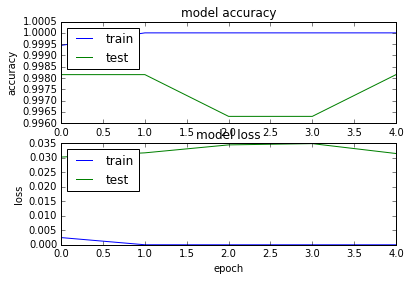

In [84]:
import matplotlib.pyplot as plt
plt.figure(1)  
   
 # summarize history for accuracy  
   
plt.subplot(211)  
plt.plot(hist.history['acc'])  
plt.plot(hist.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
   
 # summarize history for loss  
   
plt.subplot(212)  
plt.plot(hist.history['loss'])  
plt.plot(hist.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()  

In [85]:
class_dictionary = train_generator.class_indices 
inv_map = {v: k for k, v in class_dictionary.items()}  

In [86]:
import cv2
import numpy as np
file_names = []
final = []

for file in os.listdir('test'):
    name = os.path.join('test',file)
    img = load_img(name, target_size=(300,400))  
    img = img_to_array(img)  
    img = img/255
    img = np.expand_dims(img, axis=0)  
    b = res_model.predict(img)
    ans = model1.predict(b)
    ans = np.argmax(ans)
    final.append(inv_map[ans])
    file_names.append(file)
    


In [87]:
final


['Common Chickweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Fat Hen',
 'Sugar beet',
 'Shepherds Purse',
 'Loose Silky-bent',
 'Loose Silky-bent',
 'Common Chickweed',
 'Scentless Mayweed',
 'Common Chickweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Common Chickweed',
 'Fat Hen',
 'Sugar beet',
 'Cleavers',
 'Loose Silky-bent',
 'Scentless Mayweed',
 'Sugar beet',
 'Black-grass',
 'Common Chickweed',
 'Maize',
 'Black-grass',
 'Common Chickweed',
 'Sugar beet',
 'Fat Hen',
 'Maize',
 'Small-flowered Cranesbill',
 'Scentless Mayweed',
 'Small-flowered Cranesbill',
 'Small-flowered Cranesbill',
 'Charlock',
 'Scentless Mayweed',
 'Maize',
 'Loose Silky-bent',
 'Common Chickweed',
 'Fat Hen',
 'Fat Hen',
 'Small-flowered Cranesbill',
 'Sugar beet',
 'Cleavers',
 'Small-flowered Cranesbill',
 'Loose Silky-bent',
 'Common Chickweed',
 'Loose Silky-bent',
 'Sugar beet',
 'Small-flowered Cranesbill',
 'Sugar beet',
 'Cleavers',
 'Loose Silky-bent',
 'Sugar beet',
 'S

In [89]:
inv_map[0]

'Black-grass'

In [90]:
import pandas as pd

df = pd.DataFrame(data={'file': file_names, 'species': final})
df_sort = df.sort_values(by=['file'])
df_sort.to_csv('results2.csv', index=False)

In [91]:
x = pd.read_csv('results1.csv')
y = pd.read_csv('results2.csv')

In [92]:
n1 = x['species']
n2 = y['species']

In [93]:
n = 0
for i in range(len(n1)):
    if n1[i] == n2[i]:
        n = n+1
print(n/len(n1))

0.8299748110831234
